# b2__generation.py

In [181]:
import networkx as nx
import numpy as np 
import random
import math 
from numpy.linalg import matrix_rank
from scipy.linalg import qr

# My implementation

In [184]:
import math
from numpy.linalg import qr, matrix_rank

def get_adj_en(g):
    return nx.adjacency_matrix(g).todense()

def get_b1(a):
    g = nx.Graph(a)
    return (-1)*nx.incidence_matrix(g, oriented=True).todense()

def getCycles(A, max_len=math.inf):
    G = nx.DiGraph(A)
    cycles = nx.simple_cycles(G)
    
    seen = set()
    final = []
    
    for cycle in cycles:
        # Create a unique identifier for the cycle by sorting and converting to a tuple
        cycle_tuple = tuple(sorted(cycle))
        if cycle_tuple not in seen and 3 <= len(cycle) <= max_len:
            seen.add(cycle_tuple)
            final.append(cycle)
    
    final.sort(key=len)
    return final

def get_b2(a, p_max_len=math.inf):
    G = nx.Graph(a)
    E_list = list(G.edges)
    All_P = getCycles(a, p_max_len)
    cycles = [cycle + [cycle[0]] for cycle in All_P]  # Closing the cycles

    # Precompute edge indices for faster lookup
    edge_index_map = {edge: i for i, edge in enumerate(E_list)}
    
    # Initialize the matrix B2
    B2 = np.zeros((len(E_list), len(cycles)))
    
    # Populate B2
    for cycle_index, cycle in enumerate(cycles):
        for i in range(len(cycle) - 1):
            edge = (cycle[i], cycle[i + 1])
            edge_reversed = (cycle[i + 1], cycle[i])

            # Use edge indices from the map to avoid repeated searches
            if edge in edge_index_map:
                B2[edge_index_map[edge], cycle_index] = 1
            elif edge_reversed in edge_index_map:
                B2[edge_index_map[edge_reversed], cycle_index] = -1
                
    # Perform QR Decomposition without pivoting
    QR = qr(B2, pivoting=True)  # 'reduced' mode for economic QR, use 'complete' if full QR is needed
    rank = matrix_rank(B2)
    B2 = B2[:, sorted(QR[2]):rank]
    
    return B2

# Claudio's implementation

In [178]:
import networkx as nx
import numpy as np 
import random
import math 
from numpy.linalg import matrix_rank
from scipy import linalg

def get_adj(g):
  adj = np.zeros((len(g.nodes()),len(g.nodes())))
  #print(g.edges())
  for e in np.array(g.edges()):
    adj[e[0],e[1]] = 1
    adj[e[1],e[0]] = 1
  return adj


def getCycles(A,max_len=math.inf):
  ''''A = adj matrix'''
  ''''p_max_len = lenght if max cycles wanted, inf default for all cycles'''
  G = nx.DiGraph(A)
  cycles = nx.simple_cycles(G)
  final = []
  for elem in cycles:
    if sorted(elem) not in [sorted(x) for x in final]:
      final.append(elem)
  final = [c for c in final if len(c)>=3 and len(c)<= max_len]
  final.sort(key=len)
  return final


def create_B1(A):
  G = nx.Graph(A) #nx.from_numpy_matrix(A) #
  E_list = list(G.edges) 
  B1 = np.zeros([len(G.nodes),len(E_list)])
  for n in G.nodes: 
    for e in E_list:
      if n==e[0]:
        B1[n,E_list.index(e)] = 1
      elif n==e[1]:
        B1[n,E_list.index(e)] = -1 
      else:
        B1[n,E_list.index(e)] = 0
  return B1

def create_B2(A,p_max_len=math.inf):
  ''''A = adj matrix'''
  ''''p_max_len = lenght if max cycles wanted, inf default for all cycles'''
  G = nx.Graph(A) # nx.from_numpy_matrix(A) #
  E_list = list(G.edges)
  All_P = getCycles(A,p_max_len)
  cycles = [x + [x[0]] for x in All_P]
  P_list = []
  for c in cycles:
    p = []
    for i in range(len(c)-1):
      p.append([c[i],c[i+1]])
    P_list.append(p)
  B2 = np.zeros([len(E_list),len(P_list)])
  for e in E_list:
    for p in P_list:
      if list(e) in p:
        B2[E_list.index(e),P_list.index(p)] = 1
      elif [e[1],e[0]] in p:
        B2[E_list.index(e),P_list.index(p)] = -1
      else:
        B2[E_list.index(e),P_list.index(p)] = 0
  qr = linalg.qr(B2,pivoting=True)
  B2 = B2[: ,sorted(qr[2])[:matrix_rank(B2)]]
  return B2

In [172]:
n = 40
p = .2
seed = 0
G = nx.erdos_renyi_graph(n, p, seed)

In [174]:
A = get_adj(G)

In [175]:
B1 = get_b1(A)

In [183]:
B2 = get_b2(A)

KeyboardInterrupt: 

ValueError: zero-size array to reduction operation maximum which has no identity

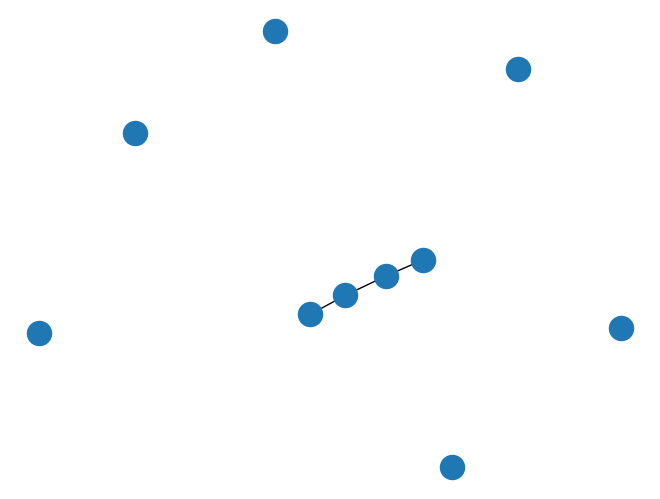

In [171]:
#Example
n = 10
p = .2
seed = 0
G = nx.erdos_renyi_graph(n, p, seed)
nx.draw(G)
A = get_adj(G)
B1 = create_B1(A)
B2 = get_b2(A,4)


In [59]:
G.number_of_edges()

19

# create_ground_truth.m

In [1024]:
import numpy as np
import numpy.linalg as la
import pandas as pd
from scipy.sparse.linalg import eigs

# __all__ = ['create_ground_truth']

def compute_Lk_and_lambdak(L, K, separated=False):
    lambdas, _ = eigs(L)
    lambdas[np.abs(lambdas) < np.finfo(float).eps] = 0
    lambda_max = np.max(lambdas)
    lambda_min = np.min(lambdas)
    Lk = np.array([la.matrix_power(L, i) for i in range(1, K + 1)])
    # for the "separated" implementation we need a different dimensionality
    if separated:
        lambda_max_k = lambda_max ** np.arange(1, K + 1)
        lambda_min_k = lambda_min ** np.arange(1, K + 1)
    else:
        lambda_max_k = lambda_max ** np.array(list(np.arange(1, K + 1))+[0])
        lambda_min_k = lambda_min ** np.array(list(np.arange(1, K + 1))+[0])
    return Lk, lambda_max_k, lambda_min_k

def generate_coeffs(*arrays, s, mult=10):
    """ 
    Select ad hoc parameters for synthetic data generation, randomly over
    an interval dependent on the max eigenvalues of the Laplacian(s)
    """

    # if passing four arguments (two for upper and two for lower laplacian eigevals)
    # it means that you are using dictionary_type="separated"
    if len(arrays)==2:
        lambda_max_k, lambda_min_k = arrays
        K = lambda_max_k.shape[0]
        h = mult / np.max(lambda_max_k) * np.random.rand(s, K)
        # For later sanity check in optimization phase 
        tmp_max_vec = h @ lambda_max_k # parallelize the code with simple matrix multiplications
        tmp_min_vec = h @ lambda_min_k
        c = np.max(tmp_max_vec)
        tmp_sum_max = np.sum(tmp_max_vec)
        tmp_sum_min = np.sum(tmp_min_vec)

        Delta_min = c - tmp_sum_min
        Delta_max = tmp_sum_max - c
        epsilon = (Delta_max - Delta_min) * np.random.rand() + Delta_min

    elif len(arrays)==4:
        lambda_max_u_k, lambda_min_u_k, lambda_max_d_k, lambda_min_d_k = arrays
        K = lambda_max_u_k.shape[0]
        hI = mult / np.max(lambda_max_d_k) * np.random.rand(s, K)
        hS = mult / np.max(lambda_max_u_k) * np.random.rand(s, K)
        hH = mult / np.min([np.max(lambda_max_u_k), np.max(lambda_max_d_k)]) * np.random.rand(s, 1)
        h = [hS, hI, hH]
        # For later sanity check in optimization phase
        tmp_max_vec_S = (hS @ lambda_max_u_k).reshape(s,1)
        tmp_min_vec_S = (hS @ lambda_min_u_k).reshape(s,1)
        tmp_max_vec_I = (hI @ lambda_max_d_k).reshape(s,1)
        tmp_min_vec_I = (hI @ lambda_min_d_k).reshape(s,1)
        c = np.max(tmp_max_vec_I + tmp_max_vec_S + hH)
        tmp_sum_min = np.sum(tmp_min_vec_I + tmp_min_vec_S + hH)
        tmp_sum_max = np.sum(tmp_max_vec_I + tmp_max_vec_S + hH)
        Delta_min = c - tmp_sum_min
        Delta_max = tmp_sum_max - c
        epsilon = np.max([Delta_min, Delta_max])
    else:
        raise ValueError("Function accepts either 2 or 4 arrays! In case of 4 arrays are provided,\
                        the first 2 refer to upper laplacian and the other two to lower laplacian.")
    return h, c, epsilon, tmp_sum_min, tmp_sum_max

def generate_dictionary(h, s, *matrices):
    D = []
    # Always check if upper and lower Laplacians are separately provided
    if len(matrices)==1:
        Lk = matrices[0]
        n = Lk.shape[-1]
        k = Lk.shape[0]
        # iterate over each kernel dimension
        for i in range(0,s):
            # Replicate formula (8) of the paper for the i-th sub-dictionary
            tmp = np.sum(h[i]*Lk, axis=0) + h[i,-1]*np.eye(n,n)
            D.append(tmp)
    elif len(matrices)==2:
        Luk , Ldk = matrices
        n = Luk.shape[-1]
        k = Luk.shape[0]
        # iterate over each kernel dimension
        for i in range(0,s):
            # Replicate formula (8) of the paper for the i-th sub-dictionary
            hu = h[0][i].reshape(k,1,1)
            hd = h[1][i].reshape(k,1,1)
            hid = h[2][i]
            tmp = np.sum(hu*Luk + hd*Ldk, axis=0) + hid*np.eye(n,n)
            D.append(tmp)
    else:
        raise ValueError("Function accepts one vector and either 1 or 2 matrices.")
    D = np.array(D).reshape(n, n*s)
    return D

def create_ground_truth(Lu, Ld, m_train, m_test, s, K, K0, dictionary_type, sparsity_mode):

    # Joint Dictionary Model
    if dictionary_type == "joint":
        Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Lu + Ld, K)
        h, c, epsilon, _, _ = generate_coeffs(lambda_max_k, lambda_min_k, s=s)
        D = generate_dictionary(h, s, Lk)

    # Edge Laplacian Dictionary Model
    elif dictionary_type == "edge_laplacian":
        Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Ld, K)
        h, c, epsilon, _, _ = generate_coeffs(lambda_max_k, lambda_min_k, s=s)
        D = generate_dictionary(h, s, Lk)

    # Separated Dictionary Model
    elif dictionary_type == "separated":
        Luk, lambda_max_u_k, lambda_min_u_k = compute_Lk_and_lambdak(Lu, K, separated=True)
        Ldk, lambda_max_d_k, lambda_min_d_k = compute_Lk_and_lambdak(Ld, K, separated=True)
        h, c, epsilon, _, _ = generate_coeffs(lambda_max_d_k, lambda_min_d_k, lambda_max_u_k, lambda_min_u_k, s=s)
        D = generate_dictionary(h, s, Luk, Ldk)

    # Signal Generation
    def create_column_vec(row):
        tmp = np.zeros(n*s)
        tmp[row['idxs']]=row['non_zero_coeff']
        return tmp
    
    m_total = m_train + m_test
    tmp = pd.DataFrame()
    # Determine the sparsity for each column based on sparsity_mode
    if sparsity_mode == "max":
        tmp_K0 = np.random.choice(np.arange(1,K0+1), size=(m_total), replace=True)
    else:
        tmp_K0 = np.full((m_total,), K0)
    # sparsity coefficient for each column
    tmp['K0'] = tmp_K0
    # for each column get K0 indexes
    tmp['idxs'] = tmp.K0.apply(lambda x: np.random.choice(n*s, x, replace=False))
    # for each of the K0 row indexes in each column, sample K0 values
    tmp['non_zero_coeff'] = tmp.K0.apply(lambda x: np.random.randn(x))
    # create the column vectors with the desired characteristics
    tmp['column_vec'] = tmp.apply(lambda x: create_column_vec(x), axis=1)
    # finally derive the sparse signal representation matrix
    X = np.column_stack(tmp['column_vec'].values)

    all_data = D @ X
    X_train = X[:, :m_train]
    X_test = X[:, m_train:]
    train_Y = all_data[:, :m_train]
    test_Y = all_data[:, m_train:]

    return D, h, train_Y, test_Y, epsilon, c, X_train, X_test

# Initialize_dic

In [1052]:
from sklearn.linear_model import OrthogonalMatchingPursuit
from tqdm import tqdm

def get_omp_coeff(K0, Domp, col):
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=K0)
    omp.fit(Domp, col)
    return omp.coef_

def initialize_dic(Lu, Ld, s, K, Y_train, K0, dictionary_type, c, epsilon, only):

    n = Lu.shape[0]
    D = np.zeros((n, n*s))
    X = np.zeros(Y_train.shape)
    X = np.tile(X, (s,1))
    discard = 0

    # maybe is better to create a wrapper
    def multiplier_search(*arrays, s=s):
        is_okay = 0
        mult = 100
        tries = 0
        while is_okay==0:
            is_okay = 1
            h, c_try, _, tmp_sum_min, tmp_sum_max = generate_coeffs(arrays, s=s, mult=mult)
            if c_try <= c:
                is_okay *= 1
            if tmp_sum_min > c-epsilon:
                is_okay *= 1
                incr_mult = 0
            else:
                is_okay = is_okay*0
                incr_mult = 1
            if tmp_sum_max < c+epsilon:
                is_okay *= 1
                decr_mult = 0
            else:
                is_okay *= 0
                decr_mult = 1
            if is_okay == 0:
                tries += 1
            if tries >3:
                discard = 1
                break
            if incr_mult == 1:
                mult *= 2
            if decr_mult == 1:
                mult /= 2
        return h, discard

    if (only == "only_D") or (only == "all"):
        X = 0
        # Joint Dictionary Model
        if dictionary_type == "joint":
            Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Lu + Ld, K)
            h, discard = multiplier_search(lambda_max_k, lambda_min_k)
            D = generate_dictionary(h, s, Lk)

        # Edge Laplacian Dictionary Model
        elif dictionary_type == "edge_laplacian":
            Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Ld, K)
            h, discard = multiplier_search(lambda_max_k, lambda_min_k)
            D = generate_dictionary(h, s, Lk)

        # Separated Dictionary Model
        elif dictionary_type == "separated":
            Luk, lambda_max_u_k, lambda_min_u_k = compute_Lk_and_lambdak(Lu, K, separated=True)
            Ldk, lambda_max_d_k, lambda_min_d_k = compute_Lk_and_lambdak(Ld, K, separated=True)
            h, discard = multiplier_search(lambda_max_d_k, lambda_min_d_k, lambda_max_u_k, lambda_min_u_k)
            D = generate_dictionary(h, s, Luk, Ldk)
    
    if (only == "only_X" or only == "all"):
        
        if dictionary_type == "edge_laplacian":
            L = Ld
        else:
            L = Lu+Ld

        _, Dx = eigs(L)
        dd = la.norm(Dx, axis=0)
        W = np.diag(1./dd)  
        Domp = Dx@W
        X = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp.real, x), axis=0, arr=Y_train.real)
        X = np.tile(X, (s,1))
        
    return D, X, discard

# Verify_dic


In [1046]:
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit

def verify_dic(D, Y_train, X_train_true, K0_max, acc_thresh):
    # OMP
    dd = la.norm(D, axis=0)
    W = np.diag(1. / dd)  # Normalization Step
    Domp = D @ W
    fin_acc = 0
    for K0 in range(1, K0_max+1):
        idx = np.sum(np.abs(X_train_true) > 0, axis=0) == K0  # select all column vectors with certain sparsity (K0 non-null elements)
        tmp_train = Y_train[:, idx].real
        ##########################
        if tmp_train.shape[1]==0:
            continue
        X_true_tmp = X_train_true[:, idx].real
        idx_group = np.abs(X_true_tmp) > 0
        X_tr = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp.real, x), axis=0, arr=tmp_train)
        idx_train = np.abs(X_tr) > 0
        acc = np.sum(np.sum(idx_group == idx_train, axis=0) == idx_group.shape[0])/idx_group.shape[1]
        if acc < 0.7:
            break
        else:
            fin_acc = acc
    # ????????
    max_possible_sparsity = K0 - 1
    return max_possible_sparsity, fin_acc


In [1058]:
# prova

# Subsampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]

# Laplacians
Ld = np.matmul(np.transpose(B1), B1, dtype=float)
Lu = np.matmul(B2, np.transpose(B2), dtype=float)
L = Lu+Ld
n =  L.shape[0]
nu = B2.shape[1]
nd = B1.shape[1]
_ ,U = la.eig(L)

# Problem and Dictionary Dimensionalities
dictionary_type_true = "separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
s_true = 3 # Number of Kernels (Sub-dictionaries)
k_true = 2 # Polynomial order
sparsity = .1 # Sparsity percentage
K0_max = 20 #floor(n*sparsity) # Sparsity
sparsity_mode = "max"

# Data-Independent Problem Hyperparameters
dictionary_type = dictionary_type_true
s = s_true
k = k_true
K0_coll = np.arange(5, 26, 4) # K0_coll = 5:4:25 %4:4:40 %5:3:20
lambda_ = 1e-6 # l2 multiplier
max_iter = 100 # Maximum number of iterations
patience = 5 # Patience
tol = 1e-7 # Tolerance for Patience
n_sim = 10
verbose = 0

# Luk, lambda_max_u_k, lambda_min_u_k = compute_Lk_and_lambdak(Lu, k, separated=True)
# Ldk, lambda_max_d_k, lambda_min_d_k = compute_Lk_and_lambdak(Ld, k, separated=True)

# h, c, epsilon, _, _ = generate_coeffs(lambda_max_d_k, lambda_min_d_k, lambda_max_u_k, lambda_min_u_k, s=s)

# D = generate_dictionary(h, s, Luk, Ldk)

In [1059]:
# D, h, Y_train, Y_test, epsilon, c, X_train, X_test = create_ground_truth(Lu,
#                                                                          Ld,
#                                                                          m_train,
#                                                                          m_test, 
#                                                                          s, 
#                                                                          k, 
#                                                                          K0_coll[0], 
#                                                                          dictionary_type, 
#                                                                          sparsity_mode)

# Topological_dictionary_learn

In [1054]:
import numpy as np
import cvxpy as cp

def topological_dictionary_learn(Y_train, Y_test, K, n, s, D0, X0, Lu, Ld, dictionary_type, c, epsilon, K0, lambda_=1e-5, max_iter=10, patience=10, tol=1e-7, verbose=0):
    h_opt =0  ##############################################
    X_opt_train=0
    X_opt_test=0  ###########################################
    # Define hyperparameters
    min_error_train_norm, min_error_test_norm = 1e20, 1e20
    m_test, m_train = Y_test.shape[1], Y_train.shape[1]
    iter_, pat_iter = 1, 0

    if dictionary_type != "fourier":
        # Joint Dictionary
        if dictionary_type == "joint":
            Lk, _, _ = compute_Lk_and_lambdak(Lu + Ld, K)
        # Separated Dictionary
        elif dictionary_type == "separated":
            Luk, _, _ = compute_Lk_and_lambdak(Lu, K, separated=True)
            Ldk, _, _ = compute_Lk_and_lambdak(Ld, K, separated=True)
        # Edge Laplacian
        elif dictionary_type == "edge_laplacian":
            Lk, _, _ = compute_Lk_and_lambdak(Ld, K)

        # Init the dictionary and the sparse representation
        D0 = D0.reshape(n,n,s)
        D_coll = [cp.Constant(D0[:,:,j]) for j in range(s)]
        X_train = X0
        while pat_iter < patience and iter_ <= max_iter:
            
            # SDP Step
            I = cp.Constant(np.eye(n))

            if dictionary_type in ["joint", "edge_laplacian"]:
                h = cp.Variable((s, K))
                hI = cp.Variable((s, 1))
                for i in range(0,s):
                    tmp =  cp.Constant(np.zeros((n, n)))
                    for j in range(0,K):
                        tmp += cp.multiply(h[i,j], Lk[j, :, :])
                    tmp += cp.multiply(hI[i,:], I)
                    D_coll[i] = tmp
                D = cp.hstack([D_coll[i]for i in range(s)])
                term1 = cp.norm(Y_train - D @ X_train, 'fro')**2
                term2 = lambda_ * cp.norm(h, 'fro')**2
                term3 = lambda_ * cp.norm(hI, 'fro')**2
                obj = cp.Minimize(term1+term2+term3)
            else:
                hI = cp.Variable((s, K))
                hS = cp.Variable((s, K))
                hH = cp.Variable((s, 1))
                for i in range(0,s):
                    hu = hS[i,:]
                    hd = hI[i,:]
                    hid = hH[i]
                    tmp =  cp.Constant(np.zeros((n, n)))
                    for j in range(0,K):
                        tmp += cp.multiply(hu[j], Luk[j, :, :]) + cp.multiply(hd[j], Ldk[j, :, :])
                    tmp += cp.multiply(hid, I)
                    D_coll[i] = tmp
                D = cp.hstack([D_coll[i]for i in range(s)])
                
                term1 = cp.norm(Y_train - D @ X_train, 'fro')**2
                term2 = lambda_ * cp.norm(hI, 'fro')**2
                term3 = lambda_ * cp.norm(hS, 'fro')**2
                term4 = lambda_ * cp.norm(hH, 'fro')**2
                obj = cp.Minimize(term1 + term2 + term3 + term4)

            Dsum = cp.sum(D_coll)
            constraints = [D_coll[i] >= 0 * I for i in range(s)] + \
                            [D_coll[i] <= c * I for i in range(s)] + \
                            [Dsum >= cp.multiply((c - epsilon), I), Dsum <= cp.multiply((c + epsilon), I)]

            prob = cp.Problem(obj, constraints)
            prob.solve(solver=cp.CLARABEL)
            # Update the dictionary
            D = D.value

            # OMP Step
            dd = la.norm(D, axis=0)
            W = np.diag(1. / dd)
            Domp = D @ W
            X_train = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp.real, col=x), axis=0, arr=Y_train.real)
            X_test = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp.real, col=x), axis=0, arr=Y_test.real)
            # Normalize?
            X_train = W @ X_train
            X_test = W @ X_test

            # Error Updating
            error_train_norm = (1/m_train)* np.sum(la.norm(Y_train - (D @ X_train), axis=0)**2 /
                                    la.norm(Y_train, axis=0)**2)
            error_test_norm = (1/m_test)* np.sum(la.norm(Y_test - (D @ X_test), axis=0)**2 /
                                    la.norm(Y_test, axis=0)**2)

            # Error Storing
            if (error_train_norm < min_error_train_norm) and (abs(error_train_norm) > np.finfo(float).eps) and (abs(error_train_norm - min_error_train_norm) > tol):
                X_opt_train = X_train
                min_error_train_norm = error_train_norm
                print("ping!")

            if (error_test_norm < min_error_test_norm) and (abs(error_test_norm) > np.finfo(float).eps) and (abs(error_test_norm - min_error_test_norm) > tol):
                h_opt = h.value if dictionary_type in ["joint", "edge_laplacian"] else np.hstack([hI.value, hS.value, hH.value])
                D_opt = D
                X_opt_test = X_test
                min_error_test_norm = error_test_norm
                pat_iter = 0
                print("ping!")
                if verbose == 1:
                    print("New Best Test Error:", min_error_test_norm)
            else:
                pat_iter += 1

            iter_ += 1

    else:
        # Fourier Dictionary Benchmark
        L = Lu + Ld
        _, D_opt = eigs(L)
        dd = la.norm(D_opt, axis=0)
        W = np.diag(1./dd)  
        Domp = D_opt@W
        X_opt_train = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp.real, col=x), axis=0, arr=Y_train.real)
        X_opt_test = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp.real, col=x), axis=0, arr=Y_test.real)
        # Normalize?
        X_opt_train = W @ X_opt_train
        X_opt_test = W @ X_opt_test
        # Error Updating
        error_train_norm = (1/m_train)* np.sum(la.norm(Y_train - (D_opt @ X_opt_train), axis=0)**2 /
                                la.norm(Y_train, axis=0)**2)
        error_test_norm = (1/m_test)* np.sum(la.norm(Y_test - (D_opt @ X_opt_test), axis=0)**2 /
                                la.norm(Y_test, axis=0)**2)
        h_opt = 0
    return h_opt, X_opt_test, X_opt_train, min_error_test_norm, min_error_train_norm


# Init param_dic.m

In [1047]:
import scipy.io
mat = scipy.io.loadmat('datiSC.mat')
B1 = mat["B1"]
B2 = mat["B2"]

In [1049]:
import numpy.linalg as la

# Subsampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]

# Laplacians
Ld = np.matmul(np.transpose(B1), B1)
Lu = np.matmul(B2, np.transpose(B2))
L = Lu+Ld
n =  L.shape[0]
nu = B2.shape[1]
nd = B1.shape[1]
_ ,U = la.eig(L)

# Problem and Dictionary Dimensionalities
dictionary_type_true = "separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
s_true = 3 # Number of Kernels (Sub-dictionaries)
k_true = 2 # Polynomial order
sparsity = .1 # Sparsity percentage
K0_max = 20 #floor(n*sparsity) # Sparsity
sparsity_mode = "max"

# Data-Independent Problem Hyperparameters
dictionary_type = dictionary_type_true
s = s_true
k = k_true
K0_coll = np.arange(5, 26, 4) # K0_coll = 5:4:25 %4:4:40 %5:3:20
lambda_ = 1e-6 # l2 multiplier
max_iter = 100 # Maximum number of iterations
patience = 5 # Patience
tol = 1e-7 # Tolerance for Patience
n_sim = 10
verbose = 0

In [729]:
# D, h, Y_train, Y_test, epsilon, c, X_train, X_test = create_ground_truth(Lu,
#                                                                          Ld,
#                                                                          m_train,
#                                                                          m_test, 
#                                                                          s, 
#                                                                          k, 
#                                                                          K0_coll[0], 
#                                                                          dictionary_type, 
#                                                                          sparsity_mode)

# D0, X0, discard = initialize_dic(Lu,
#                                  Ld, 
#                                  s, 
#                                  k, 
#                                  Y_train, 
#                                  K0_max, 
#                                  dictionary_type, 
#                                  c, 
#                                  epsilon, 
#                                  only="only_X")


# D_sim = topological_dictionary_learn(Y_train, 
#                                      Y_test, 
#                                      k, 
#                                      n, 
#                                      s, 
#                                      X_train, 
#                                      D0, 
#                                      X0, 
#                                      Lu, 
#                                      Ld, 
#                                      dictionary_type, 
#                                      c, 
#                                      epsilon, 
#                                      K0_max, 
#                                      lambda_, 
#                                      max_iter, 
#                                      patience, 
#                                      tol)

In [1062]:
import scipy.io
mat = scipy.io.loadmat('datiSC.mat')
B1 = mat["B1"]
B2 = mat["B2"]

# Subsampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]

# Laplacians
Ld = np.matmul(np.transpose(B1), B1, dtype=float)
Lu = np.matmul(B2, np.transpose(B2), dtype=float)
L = Lu+Ld
n =  L.shape[0]
nu = B2.shape[1]
nd = B1.shape[1]
_ ,U = la.eig(L)

# Problem and Dictionary Dimensionalities
dictionary_type_true = "separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
s_true = 3 # Number of Kernels (Sub-dictionaries)
k_true = 2 # Polynomial order
sparsity = .1 # Sparsity percentage
K0_max = 20 #floor(n*sparsity) # Sparsity
sparsity_mode = "max"

# Data-Independent Problem Hyperparameters
dictionary_type = dictionary_type_true
s = s_true
k = k_true
K0_coll = np.arange(5, 26, 4) # K0_coll = 5:4:25 %4:4:40 %5:3:20
lambda_ = 1e-6 # l2 multiplier
max_iter = 100 # Maximum number of iterations
patience = 5 # Patience
tol = 1e-7 # Tolerance for Patience
n_sim = 10
verbose = 0


D_true = np.zeros((n, n * s_true, n_sim))
D_true_coll = np.zeros((n, n, s_true, n_sim))
Y_train = np.zeros((n, m_train, n_sim))
Y_test = np.zeros((n, m_test, n_sim))
epsilon_true = np.zeros(n_sim)
c_true = np.zeros(n_sim)
X_train = np.zeros((n * s, m_train, n_sim))
X_test = np.zeros((n * s, m_test, n_sim))
n_search = 3000

for sim in range(6, n_sim):
    # from there I can create a function to parallelize by the number of simulations
    best_sparsity = 0
    best_acc = 0

    for i in tqdm(range(n_search)):
        # try:
        D_try, h, Y_train_try, Y_test_try, epsilon_try, c_try, X_train_try, X_test_try = create_ground_truth(Lu,
                                                                                Ld,
                                                                                m_train,
                                                                                m_test, 
                                                                                s, 
                                                                                k, 
                                                                                K0_max, 
                                                                                dictionary_type, 
                                                                                sparsity_mode)
        # Replace with your actual function to verify dictionaries
        max_possible_sparsity, acc = verify_dic(D_try, Y_train_try, X_train_try, K0_max, .7)
        if max_possible_sparsity > best_sparsity:
            best_sparsity = max_possible_sparsity
            best_acc = acc
            D_true[:, :, sim] = D_try
            # D_true_coll[:, :, :, sim] = D_true_coll_tries
            Y_train[:, :, sim] = Y_train_try
            Y_test[:, :, sim] = Y_test_try
            epsilon_true[sim] = epsilon_try
            c_true[sim] = c_try
            X_train[:, :, sim] = X_train_try
            X_test[:, :, sim] = X_test_try

        # except Exception as e:
        #     print(f"Error during dictionary creation: {e}")

    print(f"...Done! # Best Sparsity: {best_sparsity}")

  0%|          | 0/3000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [03:23<00:00, 14.76it/s]


...Done! # Best Sparsity: 9


100%|██████████| 3000/3000 [03:12<00:00, 15.55it/s]


...Done! # Best Sparsity: 9


100%|██████████| 3000/3000 [03:14<00:00, 15.43it/s]


...Done! # Best Sparsity: 8


100%|██████████| 3000/3000 [03:14<00:00, 15.44it/s]

...Done! # Best Sparsity: 8


In [1064]:
Y_train.shape

(100, 150, 10)

In [1074]:
y_tr = Y_train[:,:,1]
y_te = Y_test[:,:,0]
X_tr = X_train[:,:,0]
X_te = X_test[:,:,0]

In [1079]:
K0_coll[5]

25

In [1076]:
initialize_dic(Lu, Ld, s, k, y_tr, K0_coll[1], dictionary_type, c_true[1], epsilon_true[1], "only_X")

ValueError: The number of atoms cannot be more than the number of features

In [1073]:
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')

# Initializations of Error Storing Variables
min_error_edge_train = np.zeros((n_sim, len(K0_coll)))
min_error_joint_train = np.zeros((n_sim, len(K0_coll)))
min_error_sep_train = np.zeros((n_sim, len(K0_coll)))
min_error_fou_train = np.zeros((n_sim, len(K0_coll)))
min_error_edge_test = np.zeros((n_sim, len(K0_coll)))
min_error_joint_test = np.zeros((n_sim, len(K0_coll)))
min_error_sep_test = np.zeros((n_sim, len(K0_coll)))
min_error_fou_test = np.zeros((n_sim, len(K0_coll)))

np.random.seed(0)
verbose = 0
for sim in range(n_sim):
    c = c_true[sim]  # d
    epsilon = epsilon_true[sim]  # epsilon
    for k0_index, k0 in tqdm(enumerate(K0_coll)):
        # Initializations
        discard = 1
        print(sim)
        print(k0)
        while discard == 1:
            D0, X0, discard = initialize_dic(Lu, Ld, s, k, Y_train[:, :, sim], k0, dictionary_type, c, epsilon, "only_X")
#         try:
#             h_opt_edge, _, _, min_error_edge_train[sim, k0_index], min_error_edge_test[sim, k0_index] = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim], k, n, s, D0, X0, Lu, Ld, "edge_laplacian", c, epsilon, k0, lambda_, max_iter, patience, tol)
#             print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Edge Laplacian... Done! Test Error: {min_error_edge_test[sim, k0_index]}")
#         except Exception as e:
#             min_error_edge_train[sim, k0_index] = 100
#             min_error_edge_test[sim, k0_index] = 100
#             print(f"Divergent Run in Edge Laplacian... Discarded! Error: {e}")
#         try:
#             h_opt_joint, _, _, min_error_joint_train[sim, k0_index], min_error_joint_test[sim, k0_index] = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim], k, n, s, D0, X0, Lu, Ld, "joint", c, epsilon, k0, lambda_, max_iter, patience, tol)
#             print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Joint... Done! Test Error: {min_error_joint_test[sim, k0_index]}")
#         except Exception as e:
#             min_error_joint_train[sim, k0_index] = 100
#             min_error_joint_test[sim, k0_index] = 100
#             print(f"Divergent Run in joint... Discarded! Error: {e}")
#         try:
#             h_opt_sep, _, _, min_error_sep_train[sim, k0_index], min_error_sep_test[sim, k0_index] = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim], k, n, s, D0, X0, Lu, Ld, "separated", c, epsilon, k0, lambda_, max_iter, patience, tol)
#             print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Separated... Done! Test Error: {min_error_sep_test[sim, k0_index]}")
#         except Exception as e:
#             min_error_sep_train[sim, k0_index] = 100
#             min_error_sep_test[sim, k0_index] = 100
#             print(f"Divergent Run in Separated... Discarded! Error: {e}")


# # Plotting -----> I want to use a ppd.DataFrame for the simulations' values and then sns for plotting
# if n_sim > 1:
#     plt.semilogy(K0_coll, np.mean(min_error_fou_test, axis=0), label="Fourier")
#     plt.semilogy(K0_coll, np.mean(min_error_edge_test, axis=0), label="Edge Laplacian")
#     plt.semilogy(K0_coll, np.mean(min_error_joint_test, axis=0), label="Joint")
#     plt.semilogy(K0_coll, np.mean(min_error_sep_test, axis=0), label="Separated")
# else:
#     plt.semilogy(K0_coll, min_error_fou_test[0], label="Fourier")
#     plt.semilogy(K0_coll, min_error_edge_test[0], label="Edge Laplacian")
#     plt.semilogy(K0_coll, min_error_joint_test[0], label="Joint")
#     plt.semilogy(K0_coll, min_error_sep_test[0], label="Separated")

# plt.legend()
# plt.title(f"True dictionary: {dictionary_type_true}")
# plt.xlabel('Sparsity')
# plt.ylabel('Error')
# plt.show()


1it [00:00, 15.25it/s]

0
5
0
9


ValueError: The number of atoms cannot be more than the number of features